In [3]:
import os, sys
cwd = os.getcwd()
print(cwd)

/Users/i522408/Desktop/jupyter-Code


In [4]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [5]:

# File paths
TRAIN_TXT = 'TrainingData-set.txt'
TEST_TXT = 'TestingData-set.txt'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
#word2vec = KeyedVectors.load_word2vec_format(datapath("GoogleNews-vectors-negative300.bin"), binary=True)

In [6]:
X1train = []
X2train = []
Ytrain  = []
X1test = [] 
X2test = []
Ytest = []
test_txt = open("TestingData-set.txt", "r+")
#train_txt = open("TrainingData-set.txt", "r+")
train_txt = open("demo2.txt", "r+")
#arrange the training data
'''
i = 0 
with open("TrainingData-set.txt", "r") as f:
    lines = f.readlines()
with open("demo2.txt", "w") as f:
    for line in lines:
        s = line.split(".")
        if len(s) > 1 and i < 50000:
            if "0" in s[-1] or "1" in s[-1]:
                 f.write(line)
                 i +=1   
'''


## import the training data and get the two x columns and output column

for line in train_txt:
       #print('\n',"Line  :    ",line)
        if "1" in line:
            Ytrain.append("1")
        elif "0" in line:
            Ytrain.append("0")
        line = line.split(".")
        #print("line ",line)
        X1train.append(line[0])
        str = line[1]
        str = str[1:]
        str = str.replace('1', '')
        str = str.replace('0', '')
        X2train.append(str)
        #while("" in X2train ) : 
        #     X2train.remove("")
    
#import the testing data 
for line in test_txt:
    #print('\n',"Line  :    ",line)
    if "1" in line:
        Ytest.append("1")
    elif "0" in line:
        Ytest.append("0")
    line = line.split(".")
    #print('\n',"Line  :    ",line)
    X1test.append(line[0])
    str = line[1]
    str = str[1:]
    str = str.replace('1', '')
    str = str.replace('0', '')
    X2test.append(str)
#while("" in X2test) : 
 #     X2test.remove("")


print(len(X1train))    
print(len(X2train))
print(len(Ytrain))
#data frame for training  

d1 = {'question1': X1train, 'question2': X2train, 'is_duplicate': Ytrain}  
train_df = pd.DataFrame(d1) 
#train_df 
    
# data frame for testing
d2 = {'question1': X1test, 'question2': X2test, 'is_duplicate': Ytest}  
test_df = pd.DataFrame(d2) 
test_df  
  

    


50000
50000
50000


,question1,question2,is_duplicate
0,A bald baby laughs as he holds onto his mom's ...,the dad rocked the baby to sleep\t\n,0
1,A bald baby laughs as he holds onto his mom's ...,the baby was laughing\t\n,1
2,A large dog wards off a smaller dog,A horse is eating grass,0
3,A large dog wards off a smaller dog,a dog gnarls at another,1
4,Women holding a baby wearing a green shirt,Woman is watching a baby crawl on the ground,0
...,...,...,...
281,A dog with a blue collar plays ball outside,a dog is outside\t\n,1
282,Four dirty and barefooted children,four children have dirty feet,1
283,Four dirty and barefooted children,four kids won awards for 'cleanest feet'\t\n,0
284,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,0


In [7]:
import nltk
nltk.download('stopwords')
  


## filter out useless words 
stops = set(stopwords.words('english'))





def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    #text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i522408/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#dictionary which has X1train, X2train:
#dic = dict(zip(X1train, X2train))
#for (x,y) in dic.items():
 #   print("  X   :  "     +   x   +   "   Y  :  "  + y)
    
    


In [9]:
# Prepare embedding
vocabulary = dict()
train2Dig1 = []
# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
inverse_vocabulary = ['<unk>']
#vectors can also be instantiated from an existing file on disk in the original Google’s 
# Iterate over the questions only of both training and test datasets
#docToVec

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec



/Users/i522408/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [18]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 70
training_size = len(train_df) - validation_size

#get data for training 
X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)


#get data for testing 
Y_testing = test_df['is_duplicate']
X_testing = test_df[questions_cols]

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': X_testing.question1, 'right': X_testing.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = Y_testing.values 



# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
    
# Zero padding for testing 
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)    
    

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)




In [19]:
#Build a model 
# Model variables
n_hidden = 40
gradient_clipping_norm = 1.25
batch_size = 50
n_epoch = 15

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))



    
#dic = dict(zip(X1test, predictions))
#for (x,y) in dic.items():
 #   print("  X   :  "     +   x   +   "   Y  :  "  + y)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))



/Users/i522408/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 49930 samples, validate on 70 samples
Epoch 1/1
49930/49930 [==============================] - 124s 2ms/step - loss: 0.2316 - accuracy: 0.6392 - val_loss: 0.1956 - val_accuracy: 0.7000
Training time finished.
1 epochs in 0:02:06.161280


In [30]:
#make the testing 
predictions = malstm.predict([X_test['left'],X_test['right']],verbose=0,batch_size = 10)
pred = np.around(predictions)
predicting = []
list = pred.tolist()
for x in list:
    predicting.extend(x)
predicting = [int(i) for i in  predicting]    
print("prediction output : ",predicting)
print('\n')
Y_test = [int(i) for i in Ytest]
print("Actual output : ",Y_test)
#print(len(predicting))
#test_los , test_acc = malstm.evaluate(Y_test,predicting)
#print('Accuracy:', round(test_acc * 100, 2), '%.')


prediction output :  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]


Actual output :  [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0

In [38]:
# calculating the true and false predictins
tr = 0
fa = 0 
for i in range(len(predicting)):
    if Y_test[i] == predicting[i]:
        tr +=1
    else :
        fa +=1
print("True  :",tr)
print("False :",fa)

True  : 202
False : 84


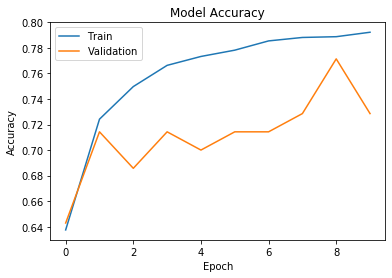

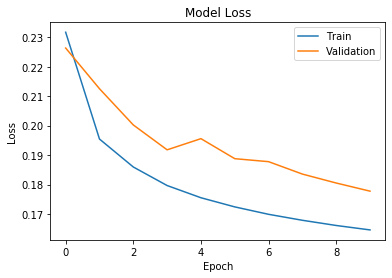

In [12]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


                     
                     